In [1]:
%matplotlib notebook
import sympy as sp
import numpy as np
import math

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\freibold.GER\AppData\Local\Temp\ipykernel_15772\1967069686.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# definitions

class BBox():
    def __init__(self, bbmin=None, bbmax=None):
        if bbmin is None:
            self.bbmin = np.array([math.inf, math.inf, math.inf, math.inf])
        else:
            self.bbmin = bbmin
        if bbmax is None:
            self.bbmax = np.array([-math.inf, -math.inf, -math.inf, -math.inf])
        else:
            self.bbmax = bbmax
        
    def extend(self, other):
        if isinstance(other, BBox):
            self.bbmin = np.minimum(self.bbmin, other.bbmin)
            self.bbmax = np.maximum(self.bbmax, other.bbmax)
        else:
            self.bbmin = np.minimum(self.bbmin, other)
            self.bbmax = np.maximum(self.bbmax, other)
    
    def extendAll(self, *others):
        for other in others:
            self.extend(other)
        
    def getCorners(self):
        corners = np.array([[self.bbmin[0], self.bbmin[1], self.bbmin[2], 1],
                            [self.bbmin[0], self.bbmin[1], self.bbmax[2], 1],
                            [self.bbmin[0], self.bbmax[1], self.bbmin[2], 1],
                            [self.bbmin[0], self.bbmax[1], self.bbmax[2], 1],
                            [self.bbmax[0], self.bbmin[1], self.bbmin[2], 1],
                            [self.bbmax[0], self.bbmin[1], self.bbmax[2], 1],
                            [self.bbmax[0], self.bbmax[1], self.bbmin[2], 1],
                            [self.bbmax[0], self.bbmax[1], self.bbmax[2], 1]])
        return corners
    
    def __str__(self):
        return "BBox\n    %s\n    %s" % (self.bbmin, self.bbmax)
    
def getFacesForBBoxCorners(c):
    faces = [[c[0][:3], c[1][:3], c[3][:3], c[2][:3]],
             [c[4][:3], c[5][:3], c[7][:3], c[6][:3]],
             [c[0][:3], c[2][:3], c[6][:3], c[4][:3]],
             [c[1][:3], c[3][:3], c[7][:3], c[5][:3]],
             [c[0][:3], c[1][:3], c[5][:3], c[4][:3]],
             [c[2][:3], c[3][:3], c[7][:3], c[6][:3]]]
    return faces

def lerp(v0,v1,t):
    return v0*(1-t)+v1*t

def motion(A0, A1, p0, p1, t):
    return lerp(A0, A1, t).dot(lerp(p0, p1, t))

def getBounds(S0, S1, p0, p1):
    bbox = BBox(np.minimum(motion(S0, S1, p0, p1, 0), motion(S0, S1, p0, p1, 1)),
                np.maximum(motion(S0, S1, p0, p1, 0), motion(S0, S1, p0, p1, 1)))
    
    denom = 2.0 * (S0-S1).dot(p0-p1)
    nom   = 2.0 * S0.dot(p0) - S0.dot(p1) - S1.dot(p0)
    
    #denom = [(S0[0][0]*p0[0] - S0[0][0]*p1[0] + S0[0][1]*p0[1] - S0[0][1]*p1[1] + S0[0][2]*p0[2] - S0[0][2]*p1[2] - S1[0][0]*p0[0] + S1[0][0]*p1[0] - S1[0][1]*p0[1] + S1[0][1]*p1[1] - S1[0][2]*p0[2] + S1[0][2]*p1[2]),
    #         (S0[1][0]*p0[0] - S0[1][0]*p1[0] + S0[1][1]*p0[1] - S0[1][1]*p1[1] + S0[1][2]*p0[2] - S0[1][2]*p1[2] - S1[1][0]*p0[0] + S1[1][0]*p1[0] - S1[1][1]*p0[1] + S1[1][1]*p1[1] - S1[1][2]*p0[2] + S1[1][2]*p1[2]),
    #         (S0[2][0]*p0[0] - S0[2][0]*p1[0] + S0[2][1]*p0[1] - S0[2][1]*p1[1] + S0[2][2]*p0[2] - S0[2][2]*p1[2] - S1[2][0]*p0[0] + S1[2][0]*p1[0] - S1[2][1]*p0[1] + S1[2][1]*p1[1] - S1[2][2]*p0[2] + S1[2][2]*p1[2])]
    #nom =   [(S0[0][0]*p0[0] - 0.5*S0[0][0]*p1[0] + S0[0][1]*p0[1] - 0.5*S0[0][1]*p1[1] + S0[0][2]*p0[2] - 0.5*S0[0][2]*p1[2] + 0.5*S0[0][3] - 0.5*S1[0][0]*p0[0] - 0.5*S1[0][1]*p0[1] - 0.5*S1[0][2]*p0[2] - 0.5*S1[0][3]),
    #         (S0[1][0]*p0[0] - 0.5*S0[1][0]*p1[0] + S0[1][1]*p0[1] - 0.5*S0[1][1]*p1[1] + S0[1][2]*p0[2] - 0.5*S0[1][2]*p1[2] + 0.5*S0[1][3] - 0.5*S1[1][0]*p0[0] - 0.5*S1[1][1]*p0[1] - 0.5*S1[1][2]*p0[2] - 0.5*S1[1][3]),
    #         (S0[2][0]*p0[0] - 0.5*S0[2][0]*p1[0] + S0[2][1]*p0[1] - 0.5*S0[2][1]*p1[1] + S0[2][2]*p0[2] - 0.5*S0[2][2]*p1[2] + 0.5*S0[2][3] - 0.5*S1[2][0]*p0[0] - 0.5*S1[2][1]*p0[1] - 0.5*S1[2][2]*p0[2] - 0.5*S1[2][3])]
    
    #for i in range(3):
    #    if (abs(denom[i]) > 0):
    #        t = nom[i] / denom[i]
    #        if (t <= 1 and t >= 0):
    #            bbox.extend(motion(S0, S1, p0, p1, t))
    return bbox

In [3]:
# computations

A0 = np.array([[ 2.0,  0.1, -0.2,  0.5],
               [ 0.0,  2.0,  0.2,  0.0],
               [ 0.0,  0.0,  2.0, -0.5],
               [ 0.0,  0.0,  0.0,  1.0]])
A1 = np.array([[ 0.0,  0.0,  1.0, -0.1],
               [ 0.0,  1.0,  0.0,  0.2],
               [-1.0,  0.0,  0.0,  0.1],
               [ 0.0,  0.0,  0.0,  1.0]]) 
t0 = np.array([[-0.1,  0.0, -0.1,  1.0], [ 0.1, 0.0, -0.1,  1.0], [ 0.0, -0.1,  0.1,  1.0]])
t1 = np.array([[-0.1,  1.0,  1.1,  1.0], [-0.1, 1.0,  0.9,  1.0], [ 0.1,  1.1,  1.0,  1.0]])

# faster bounding box (if the number of vertices is large):
# bounding the motion bounds of each bounding box corner pair
bbox_t0 = BBox()
bbox_t0.extendAll(t0[0], t0[1], t0[2])
bbox_t1 = BBox()
bbox_t1.extendAll(t1[0], t1[1], t1[2])

c0 = bbox_t0.getCorners()
c1 = bbox_t1.getCorners()

bbox_corners = BBox()
for i in range(8):
    bbox_corners.extend(getBounds(A0, A1, c0[i], c1[i]))

# compute correct bounding box:
# bounding the motion bounds of each vertex
bbox_vertices = BBox()
for i in range(3):
    bbox_vertices.extend(getBounds(A0, A1, t0[i], t1[i]))
    
times = np.linspace(0, 1, 40)
motion_corners  = np.array([[motion(A0, A1, c0[i], c1[i], t) for t in times] for i in range(8)])
motion_vertices = np.array([[motion(A0, A1, t0[i], t1[i], t) for t in times] for i in range(3)]) 

# some more data for plotting
c0 = np.array([A0.dot(c0[i]) for i in range(8)])
c1 = np.array([A1.dot(c1[i]) for i in range(8)])

f0 = getFacesForBBoxCorners(c0)
f1 = getFacesForBBoxCorners(c1)

# triangle vertices and faces
tv = np.array([A0.dot(t0[0]), A0.dot(t0[1]), A0.dot(t0[2]), A1.dot(t1[0]), A1.dot(t1[1]), A1.dot(t1[2])])
tf = [[tv[0][:3], tv[2][:3], tv[1][:3]], [tv[3][:3], tv[5][:3], tv[4][:3]]]

[[ 0.32 -0.02 -0.7   1.  ]
 [ 0.72 -0.02 -0.7   1.  ]
 [ 0.47 -0.18 -0.3   1.  ]
 [ 1.    1.2   0.2   1.  ]
 [ 0.8   1.2   0.2   1.  ]
 [ 0.9   1.3   0.    1.  ]]
[0.32 0.72 0.47 1.   0.8  0.9 ]
[-0.02 -0.02 -0.18  1.2   1.2   1.3 ]
[-0.7 -0.7 -0.3  0.2  0.2  0. ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


<IPython.core.display.Javascript object>


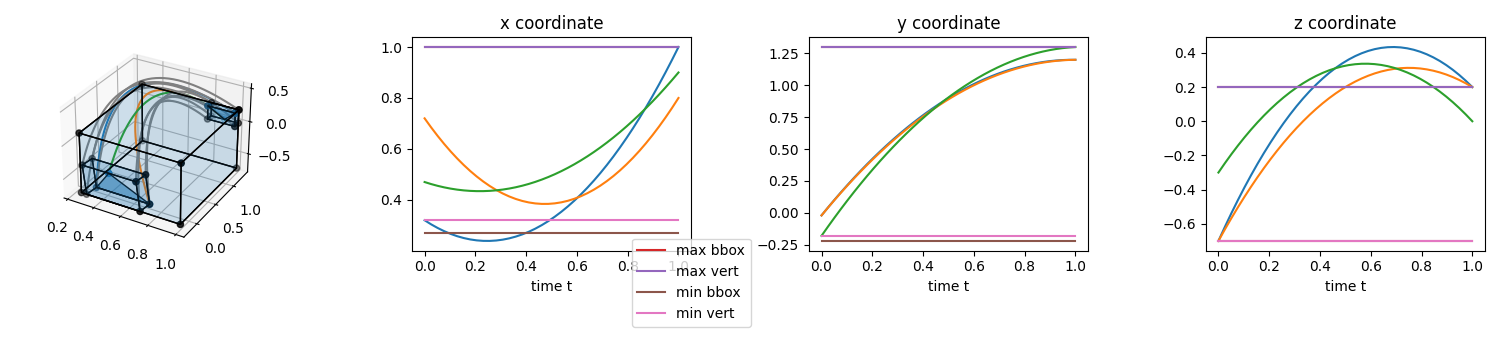

In [4]:
#plotting

print(tv)
print(tv[:,0])
print(tv[:,1])
print(tv[:,2])

print(type(tv))
print(type(tv[:,0]))
print(type(tv[:,1]))
print(type(tv[:,2]))

labels = ['x coordinate', 'y coordinate', 'z coordinate']
fig = plt.figure(figsize=(15, 3.5))
ax = fig.add_subplot(1, 4, 1, projection='3d')
for i in range(3):
    ax.plot(motion_vertices[i][:,0], motion_vertices[i][:,1], motion_vertices[i][:,2])
ax.scatter3D(tv[:,0], tv[:,1], tv[:,2])
ax.add_collection3d(Poly3DCollection(tf, linewidth=1, edgecolors='black', alpha=0.5))
ax.scatter3D(c0[:,0], c0[:,1], c0[:,2], color='black')
ax.scatter3D(c1[:,0], c1[:,1], c1[:,2], color='black')
ax.add_collection3d(Poly3DCollection(f0, linewidth=1, edgecolors='black', alpha=0.1))
ax.add_collection3d(Poly3DCollection(f1, linewidth=1, edgecolors='black', alpha=0.1))
for i in range(8):
    ax.plot(motion_corners[i][:,0], motion_corners[i][:,1], motion_corners[i][:,2], color='gray')
verts = bbox_corners.getCorners()
faces = getFacesForBBoxCorners(verts)
ax.scatter3D(verts[:,0], verts[:,1], verts[:,2], color='black')
ax.add_collection3d(Poly3DCollection(faces, linewidth=1, edgecolors='black', alpha=0.1))

for i in range(0,3):
    ax = fig.add_subplot(1, 4, i+2)
    ax.set_title(labels[i])
    ax.set_xlabel("time t")
    for j in range(3):
        ax.plot(times, motion_vertices[j][:,i])
    ax.plot(times, [bbox_corners.bbmax[i]  for x in times], label="max bbox")
    ax.plot(times, [bbox_vertices.bbmax[i] for x in times], label="max vert")
    ax.plot(times, [bbox_corners.bbmin[i]  for x in times], label="min bbox")
    ax.plot(times, [bbox_vertices.bbmin[i] for x in times], label="min vert")
    if i == 0:
        ax.legend(loc='center', bbox_to_anchor=(1, -0.15))
plt.tight_layout()
plt.savefig('plot.png')